# Denoising Diffusion Probabilistic Models

> In this module, we synthesize slowai to implement unconditional DDPM

Adapted from:

- [https://youtu.be/ItyO8s48zdc?si=kJBUmXzJ2ihUj63b&t=737](https://youtu.be/ItyO8s48zdc?si=kJBUmXzJ2ihUj63b&t=737)

In [1]:
#| default_exp ddpm

In [29]:
# |export
import random
import re
from contextlib import contextmanager
from math import sqrt
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
from diffusers import LMSDiscreteScheduler
from einops import rearrange
from IPython.display import Markdown, display
from torch import distributions, nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy
from torchvision import transforms

from slowai.activations import StoreModuleStatsCB, set_seed
from slowai.augmentation import train
from slowai.initializations import init_leaky_weights, set_seed
from slowai.learner import (
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    after,
    batchify,
    def_device,
    fashion_mnist,
)
from slowai.resnets import Conv, ResidualConvBlock
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [30]:
plt.style.use("ggplot")

The diffusion model paper is available [here](https://arxiv.org/pdf/2006.11239.pdf) and proposes an important simplification that improved the performance of this kind of modeling.

:::{.callout-tip}
## Is diffusion ideal for generating images?
Jeremy mentions that, even shortly after the Stable Diffusion release, better models were in progress that had comparable performance that do not use diffusion. "Iterative refinement" may be a better term.
:::

## Review, lesson 9b

"Generative modeling" produces some complicated probability distribution, such that sampling produces a complicated example. GAN's and VAE's can produce such a distribution, and **iterative refinement models** can do so as well.

![https://miro.medium.com/v2/resize:fit:1200/1*MLRitrnUdOy6rPtZfNwO4w.png](https://miro.medium.com/v2/resize:fit:1200/1*MLRitrnUdOy6rPtZfNwO4w.png) 

The essential equation we'll be dealing with is $$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} (x_{t-1}), \beta_t I)
$$

During the forward process of diffusion, the mean decreases and the variance increases. In other words, the original image is lost and is replaced by pure noise.

It's easy to compute the forward process for a given $X$ and $t$. The backwards process is modeled as a "simple" neural network that **predicts the mean** and uses a fixed variance.

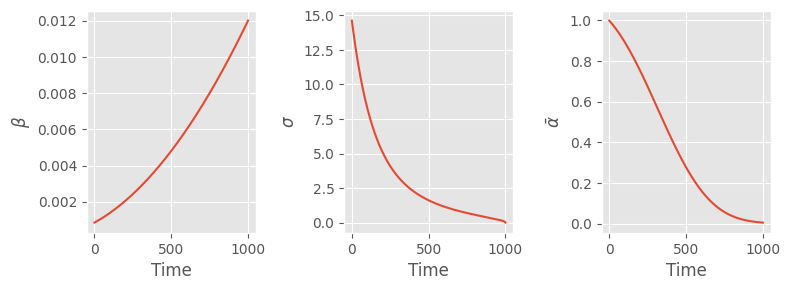

In [31]:
s = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(8, 3))
a0.plot(s.betas)
a0.set(xlabel="Time", ylabel=r"$\beta$")
a1.plot(s.sigmas)
a1.set(xlabel="Time", ylabel=r"$\sigma$")
a2.plot(s.alphas_cumprod)
a2.set(xlabel="Time", ylabel=r"$\bar{\alpha}$")
fig.tight_layout()

To review:

- $\beta$ and $\sigma$ are the mean and standard deviation (respectively) of the noise added to the image at each step
- $\bar{\alpha}$ is the cumulative amount of noise added at a particular time

By iteratively predicting the noise and removing it, ultimately we end up with a high probability data point.

# Architecture

Our model is a U-Net, with some modern tricks like attention.


![https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [32]:
from diffusers import UNet2DModel

dls = fashion_mnist()

In [33]:
def get_unet():
    return UNet2DModel(
        in_channels=1,
        out_channels=1,
        block_out_channels=(32, 64, 128, 128),
    )


get_unet().down_blocks[0]

DownBlock2D(
  (resnets): ModuleList(
    (0-1): 2 x ResnetBlock2D(
      (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
      (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
      (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlinearity): SiLU()
    )
  )
  (downsamplers): ModuleList(
    (0): Downsample2D(
      (conv): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
)

## DDPM

The training algorithm is:

1. Randomly selecting a timepoint, $t$ and add the apropriate amount of noise to the image
2. Predict the added noise and train with MSE loss

Specifically, we need the equation from the paper **Algorithm 1**.

$$
MSE \left( \epsilon_\theta(x_t), \sqrt{\bar{\alpha_t}} x_0 + (1-\sqrt{\bar{\alpha_t}} \epsilon \right)
$$

In [50]:
class TrainDDPM(TrainCB, order=after(DeviceCB)):
    def __init__(self, n_steps, βmin, βmax):
        self.n_steps = n_steps
        self.βmin = βmin
        self.βmax = βmax
        self.β = torch.linspace(βmin, βmax, n_steps)
        self.ɑ = 1 - self.β
        self.ᾱ = torch.cumprod(self.ɑ, dim=0)
        self.σ = self.β.sqrt()

    def before_batch(self, learn):
        x_0, _ = learn.batch
        device = x_0.device
        ε = torch.randn(x_0.shape, device=device)
        self.ᾱ = self.ᾱ.to(device)
        n, *_ = x_0.shape
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        x_t = ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t.sqrt()) * ε
        learn.batch = (x_t, t, ε)

    def predict(self, learn):
        x_t, t, _ = learn.batch
        learn.preds = learn.model(x_t, t).sample

    @torch.no_grad()
    def sample(self, model, sz, device=def_device):
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            ...
        raise NotImplementedError

In [51]:
def train(model, lr=4e-3, n_epochs=5):
    dls = fashion_mnist()
    T_max = len(dls["train"]) * n_epochs
    Learner(
        model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=[
            MetricsCB(MulticlassAccuracy(num_classes=10)),
            DeviceCB(),
            ProgressCB(plot=True),
            BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max),
            TrainDDPM(1000, 1e-4, 0.02),
        ],
        opt_func=torch.optim.AdamW,
    ).fit(n_epochs)

In [52]:
train(get_unet())

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 7 for tensor number 1 in the list.

In [37]:
#| hide
import nbdev

nbdev.nbdev_export()

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/Users/jeremiahfisher/Code/SlowAI/nbs/hack.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
